In [ ]:
p = 7514777789

X = []
Y = []
for line in open('encoded.txt', 'r').read().strip().split('\n'):
    x, y = line.split(' ')
    X.append(int(x))
    Y.append(int(y))

try:
    K = GF(p)
    R = PolynomialRing(K, 'x')
except NameError:
    raise Exception("SageMath kernel is required to run this script!")


# Fast interpolation algorithm
The following algorithm is taken from [1, chapter 10].

Given our input $x_0, \ldots, x_{n-1}$, and $y_0, \ldots, y_{n-1}$, we will construct the interpolating polynomial using the barycentric form 
$$ L(x) = Z(x) \sum_j \frac{w_j}{x-x_j}y_j $$
of the Lagrange polynomial. Here, $Z(x) = \Pi_j (x-x_j)$, and $w_j = \Pi_{m\neq j}(x_j - x_m)^{-1}$.

The algorithm only has complexity $O(M(n)\log n)$, where $M(n)$ is the complexity of multiplication of polynomials.

1. Compute $Z(x)$ by building up a subproduct tree. 
2. Use the subproduct tree to do fast evaluation of $Z'(x)$ by dividing down the subproduct tree to construct the weights $w_j$.
3. Use a dvide-and-conquer algorithm to construct our polynomial

## Building Up The Subproduct Tree

Note: For simplicity, we assume $n = 2^k$. The general case is similar. We denote by $\log := \log_2$ the binary logarithm.

The idea is to split the point set $\{x_0, \ldots, x_{n-1}\}$ into two halves, and to proceed recursively with each of the two halves. As a result, we get a binary tree of depth $\log n$ with root $\{x_0, \ldots, x_{n-1}\}$ and leaves $\{x_i\}$.

Instead of taking the points $\{x_0, \ldots, x_{n-1}\}$, we can also take the polynomial $Z(x) = \Pi_j(x-x_j)$ as root of the tree, and get a binary tree, where the leaves are the monomials $x-x_i$.

![Subproduct tree of the polynomial Z(x)](tex/tree.png "Subproduct tree of the polynomial Z(x)")

The algorithm [1, Algorithm 10.3], builds up $Z(x)$ by starting at the monomials and going up to the root.
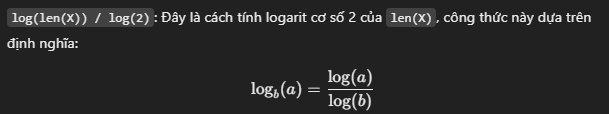



In [13]:

class Tree():
    def __init__(self, poly, X, left=None, right=None):
        self.left = left            # Node con bên trái 
        self.right = right          # Node con bên phải 
        self.poly = poly            # Đa thức liên quan
        self.X = X                  # Danh sách các giá trị tương ứng với node, lưu trữ các đầu vào của đa thức.

    def __len__(self):
        return len(self.X)

    def __call__(self, *args, **kwds):
        self.poly(*args, **kwds)

    def __mul__(self, other):
        return Tree(self.poly * other.poly, self.X + other.X, self, other)

    def __call__(self, *args, **kwds):
        return self.poly(*args, **kwds)


def compTree(X):
    x = R.gen()         # Tạo một số x

    height = ceil(log(len(X)) / log(2))         # làm tròn lên, (log_b(a) = log(a)/log(b))

    nodes = []

    for xk in X:
        nodes.append(Tree(R(x-xk), [xk]))

    for i in range(1, height):
        new_nodes = []
        for j in range(0, len(nodes)-1, 2):
            node = nodes[j] * nodes[j+1]
            new_nodes.append(node)
        if len(nodes) % 2 == 1:
            new_nodes.append(nodes[-1])
        nodes = new_nodes

    assert(len(nodes) == 2)
    return nodes[0] * nodes[1]

## Fast multipoint evaluation

This is basically an application of the chinese remainder theorem, which gives us an isomorphism
$$ \begin{align*} \chi: K[x]/\langle Z(x) \rangle & \to K^n \\ f &\mapsto (f(x_0), \ldots, f(x_{n-1}) \end{align*} $$

The idea is that we can use the identity $f(x_j) = f \mathbin{\text{rem}} (x-x_j)$ to evaluate $f$. Recall that the remainder $r = f \mathbin{\text{rem}} d$ with respect to $d$ is the remainder $r$ of the polynomial division of $f$ and $d$, i.e., $f = qd + r$. So if we chose our divisor $d$ such that $d(x_j) = 0$, then $f(x_j) = q(x_j)d(x_j) + r(x_j) = r(x_j)$. Together with the subproduct tree, we can use this to recursively decrease the degree of the polynomial we need to evaluate on.

In [ ]:

def fastEval(f, tree):
    if f.degree() < 2 or tree.poly.degree() < 2:
        if tree.poly.degree() == 1:
            return [f(-tree.poly(0))]
        if f.degree() == 0:
            print("degree 0")
            return [f]

    A = B = 0
    if tree.left:
        _, r1 = f.quo_rem(tree.left.poly)
        A = fastEval(r1, tree.left)
    else:
        print("left empty")
    if tree.right:
        _, r2 = f.quo_rem(tree.right.poly)
        B = fastEval(r2, tree.right)
    else:
        print("right empty")
    return A + B

In [14]:
def test(X):
    tree = compTree(X)
    Z1 = tree.left
    Z2 = tree.right
    Y1 = fastEval(Z2.poly, Z1)
    Y2 = fastEval(Z1.poly, Z2)

    assert(len(Y1) == len(Z1.X))
    assert(len(Y2) == len(Z2.X))

    for i in range(0, len(Z1.X)):
        assert(Y1[i] == Z2.poly(Z1.X[i]))

    for i in range(0, len(Z2.X)):
        assert(Y2[i] == Z1.poly(Z2.X[i]))

test(X[:931])

## Calculating Weights

We use the fact that
$$ Z'(x) = \sum_k \Pi_{i\neq k}(x-x_i). $$
Thus, $Z'(x_j) = \Pi_{i\neq j}(x_j-x_i) = {w_j}^{-1}$.

In [15]:
def calcWeights(Y, tree):
    print("calculating deriviative")
    Zp = tree.poly.derivative()
    print("evaluating")
    Wj = fastEval(Zp, tree)
    print("putting it together")
    return [y/w for y, w in zip(Y, Wj)]

## Fast interpolation

[1, Algorithm 10.9], [1, Algorithm 10.11]

Let $c_i = y_i/w_i$. We construct the polynomial $\sum_i c_i \frac {Z(x)}{x-x_i}$ recursively:


In [ ]:
def _fast_interpolate(weights, tree):
    if len(tree) == 1:
        return weights[0]

    W1 = weights[:len(tree.left)]
    W2 = weights[len(tree.left):]

    r0 = _fast_interpolate(W1, tree.left)
    r1 = _fast_interpolate(W2, tree.right)

    return r0 * tree.right.poly + r1 * tree.left.poly

def fast_interpolate(X, Y):
    print("computing tree")
    tree = compTree(X)
    print("computing weights")
    weights = calcWeights(Y, tree)
    print("interpolating...")
    return _fast_interpolate(weights, tree)

def test():
    Xt = X[:10000]
    Yt = Y[:10000]

    f = fast_interpolate(Xt, Yt)
    for x, y in zip(Xt, Yt):
        assert f(x) == y

test()

In [ ]:
f = fast_interpolate(X, Y)

open("output.bmp", "wb").write(bytearray(f.coefficients(sparse=False)[:-1]))

[1] von zur Gathen, Joachim Gerhard, Jürgen - Modern Computer Algebra, third edition, 2013, Cambridge Press